## Determinare la qualità di un vino date le sostanze chimiche al suo interno

Programmazione di Applicazioni Data Intensive  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Fabio Fattori

### Analisi esplorativa e del problema 

##### Problema
Si deve realizzare un modello che date le sostanze chimiche di un determinato vino determinarne la qualità 

##### Librerie utilizzate
Di seguito sono presenti le dipendenze necessarie per il funzionamento del progetto:

In [145]:
%matplotlib inline
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns

##### Significato delle Feature e lavorazioni del dataset
Le feature presenti nel dataset sono:  
| Nome  | Descrizione | Tipo Feature | Tipo Dato |
| :-----: | :--------- | :-------:  | :-------:  |
| fixed acidity  | Quantità di acidi non volatili presenti nel vino. Questi acidi contribuiscono alla stabilità e al gusto del vino. | Examination Feature | float |
| volatile acidity | Quantità di acidi volatili. Livelli elevati possono conferire al vino un odore sgradevole simile all'aceto. | Examination Feature | float |
| citric acid  | Presenza di acido citrico, che può aggiungere freschezza e sapore al vino. | Examination Feature | float |
| residual sugar | Quantità di zuccheri residui non fermentati. Livelli più alti indicano un vino più dolce. | Examination Feature | float |
| chlorides  | Contenuto di sali. Influisce sulla salinità e sul gusto del vino. | Examination Feature | float |
| free sulfur dioxide  | Quantità di anidride solforosa libera, utilizzata per prevenire la crescita microbica e l'ossidazione. | Examination Feature | float |
| total sulfur dioxide | Quantità totale di anidride solforosa, inclusa quella legata e libera. Livelli elevati possono influenzare negativamente l'aroma e il gusto. | Examination Feature | float |
| density | Densità del vino, che può essere influenzata dal contenuto di zuccheri e alcol. | Examination Feature | float |
| pH | Misura dell'acidità o basicità del vino. Valori più bassi indicano maggiore acidità. | Examination Feature | float |
| sulphates | Presenza di solfati, che possono contribuire alla stabilità microbiologica e al sapore del vino. | Examination Feature | float |
| alcohol | Percentuale di alcol presente nel vino. | Examination Feature | float |
| type | Colore del vino. | Objective Feature | object - string |
| quality | Punteggio della qualità del vino assegnato da degustatori esperti, su una scala da 0 a 10. | Target Variable | Integer |


Importo il dataset di <a href="https://www.kaggle.com/datasets/rajyellow46/wine-quality">kaggle</a> necessario che contiene misurazioni sulle sostanze chimiche presenti nei vini presi in esame.  


In [146]:
path = kagglehub.dataset_download("rajyellow46/wine-quality")

csv_file = os.path.join(path, "winequalityN.csv")
WineQualities = pd.read_csv(csv_file)
print(WineQualities.info(verbose=False, memory_usage='deep'))
WineQualities.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Columns: 13 entries, type to quality
dtypes: float64(11), int64(1), object(1)
memory usage: 948.7 KB
None


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Tutti i dati sono o float o integer, c'è solo una stringa, quindi anche osservando il peso dell'intero dataset potrei anche lasciarlo come è senza convertire l'object, ma dato che è una operazione da poco posso anche convertirlo in un intero per risparmiare più spazio possibile:  

In [147]:
WineQualities.rename(columns={"type" : "color"}, inplace=True)
WineQualities["color"] = WineQualities["color"].map({"red": 1, "white": 0})
WineQualities = WineQualities.astype({"color": "int8"})
print(WineQualities.info(verbose=False, memory_usage='deep'))
WineQualities.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Columns: 13 entries, color to quality
dtypes: float64(11), int64(1), int8(1)
memory usage: 615.6 KB
None


,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


##### Analisi generale dei dati

In [148]:
# Utilities Functions
def getWhites(df):
    return df[df["color"] == 0]

def getReds(df):
    return df[df["color"] == 1]

def getGoodReds(df):
    return df[(df["color"] == 1) & (df["quality"] >= 7)]

def getGoodWhites(df):
    return df[(df["color"] == 0) & (df["quality"] >= 7)]

def getBadReds(df):
    return df[(df["color"] == 1) & (df["quality"] < 7)]

def getBadWhites(df):
    return df[(df["color"] == 0) & (df["quality"] < 7)]

Alcuni dati, come possiamo notare sotto, sono null e per capire se può rappresentare un problema o no per i modelli che andrò a realizzare poi cerchiamo di comprendere di più sul dominio applicativo degli stessi attraverso alcuno statistiche:

In [149]:
WineQualities.describe()

,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,0.246114,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,0.430779,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,0.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,0.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,0.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


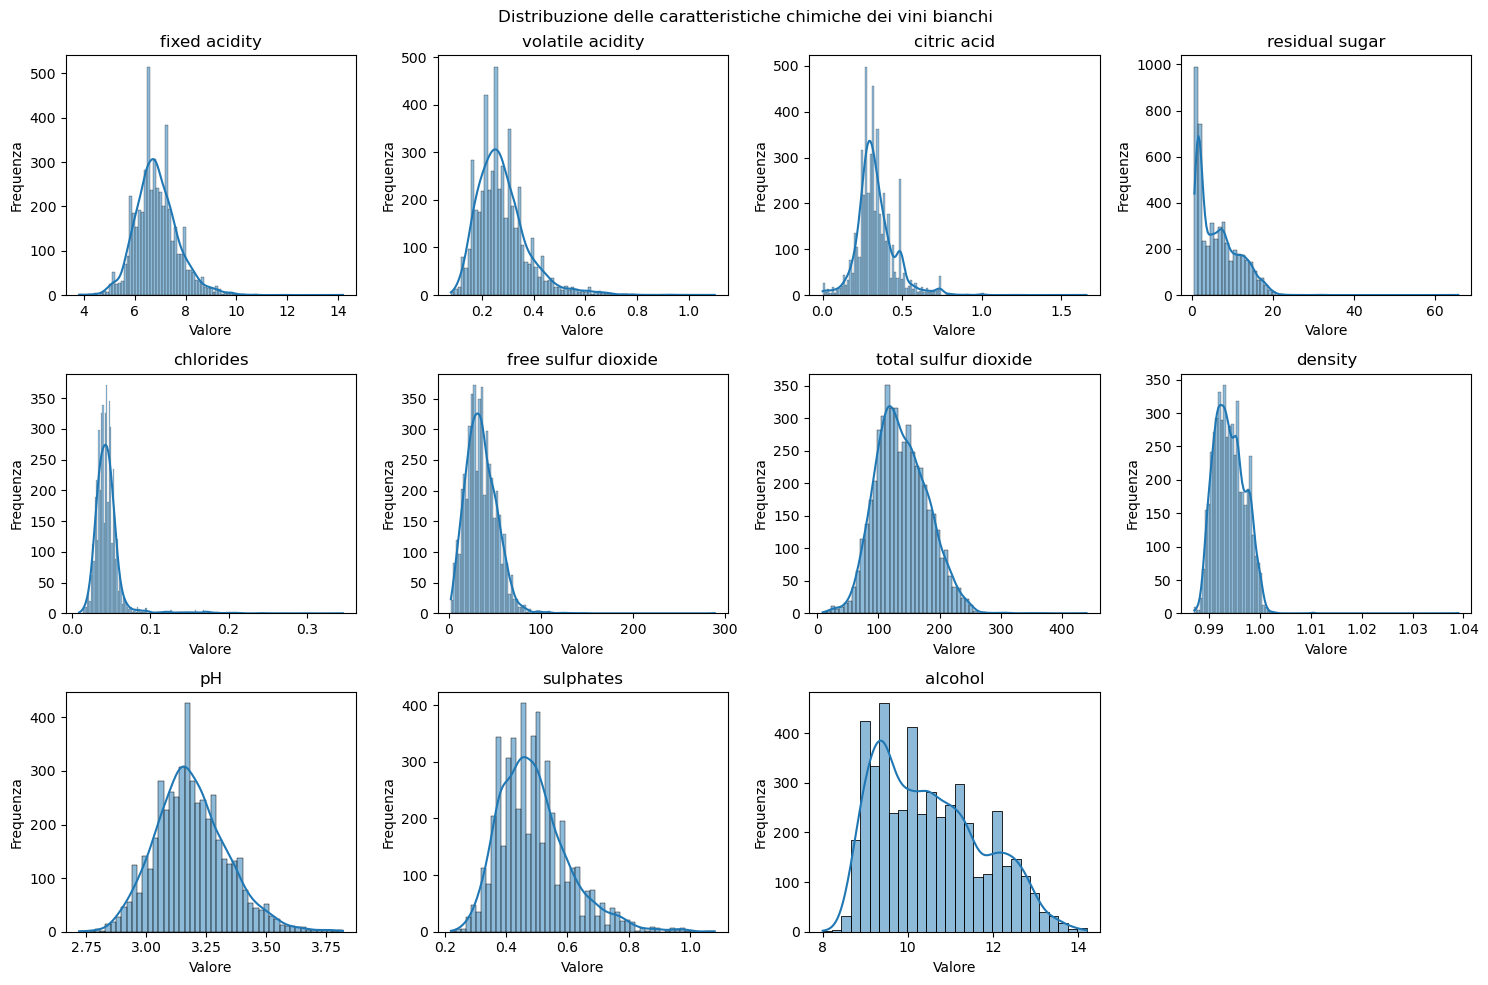

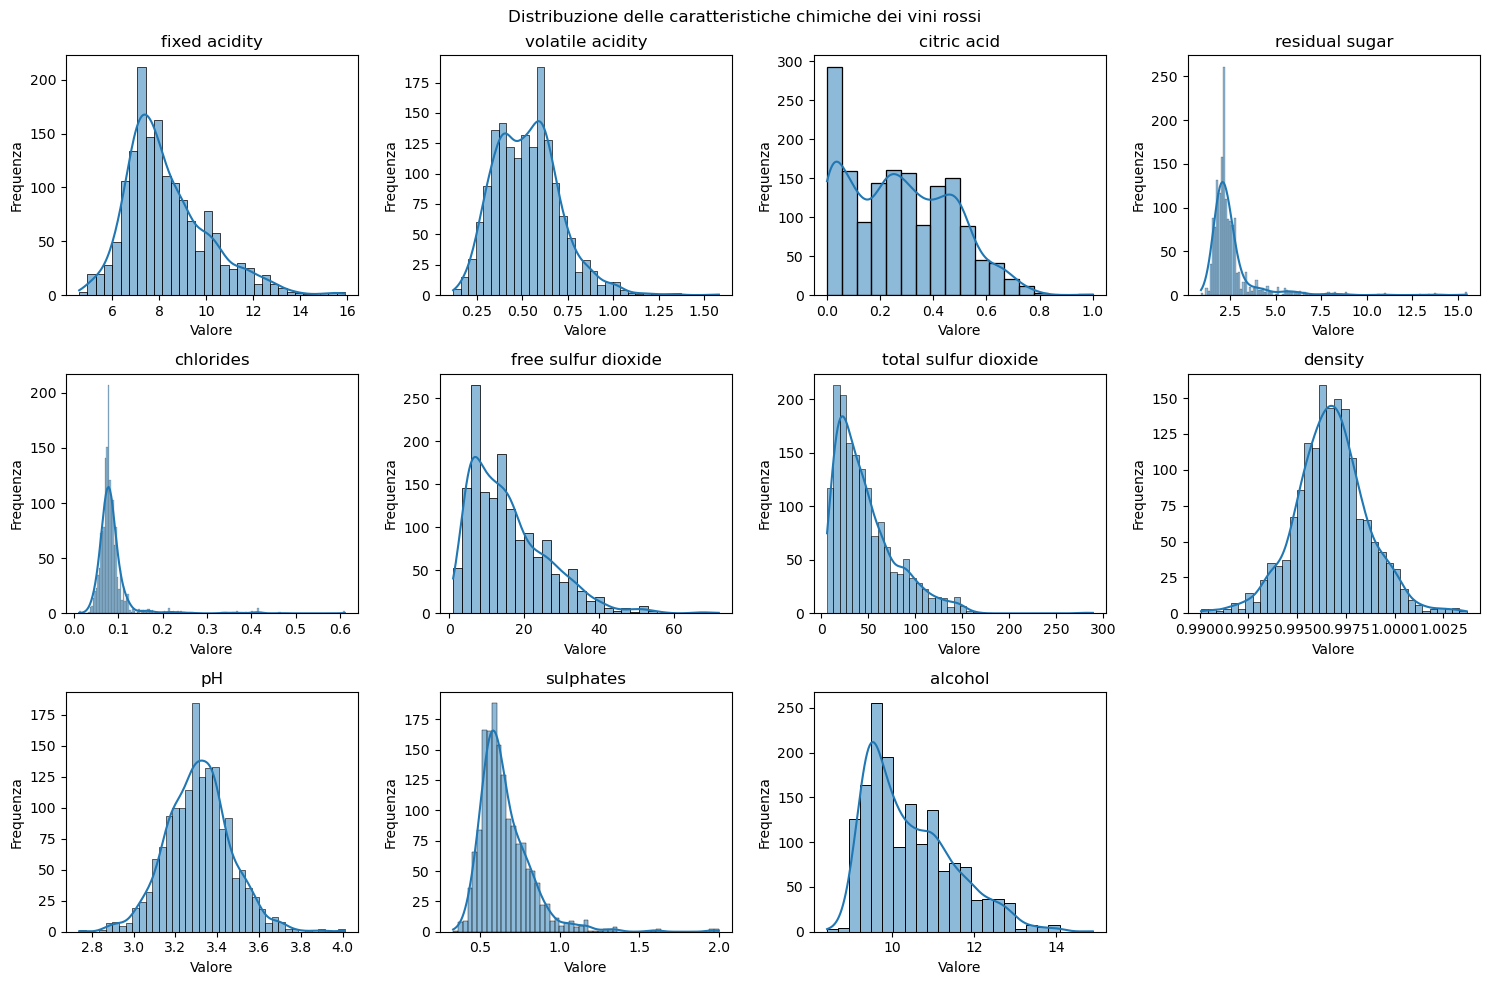

In [150]:
whites = getWhites(WineQualities)
reds = getReds(WineQualities)

chemical_features = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
    'pH', 'sulphates', 'alcohol'
]

def showHistograms(values, title):
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(chemical_features):
        plt.subplot(3, 4, i + 1)
        sb.histplot(values[feature], kde=True)
        plt.title(feature)
        plt.xlabel('Valore')
        plt.ylabel('Frequenza')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

showHistograms(whites, 'Distribuzione delle caratteristiche chimiche dei vini bianchi')
showHistograms(reds, 'Distribuzione delle caratteristiche chimiche dei vini rossi')

Ad esempio controlliamo quanti vini presi in esamina sono "buoni", con questo termine intendo che hanno un punteggio di qualità >= 7:

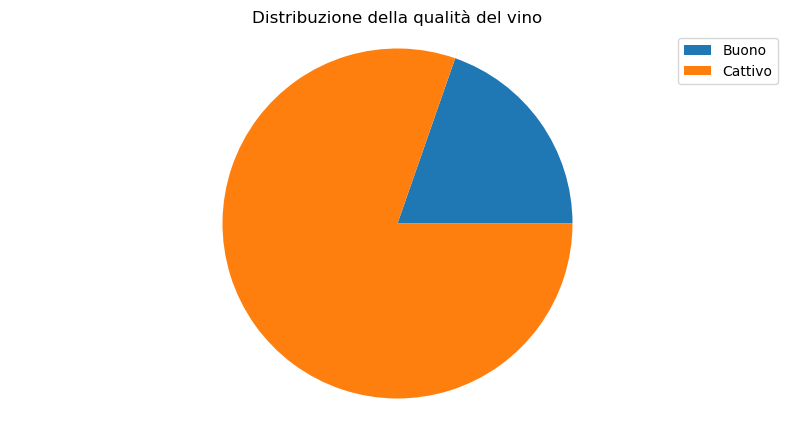

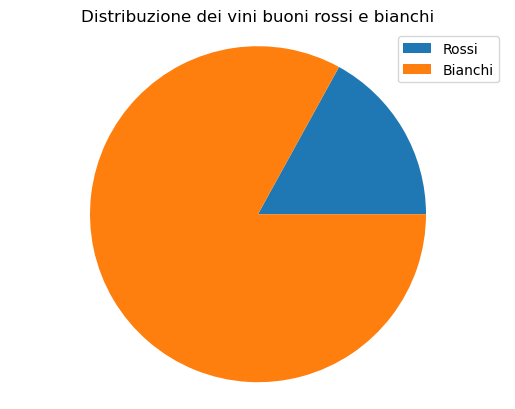

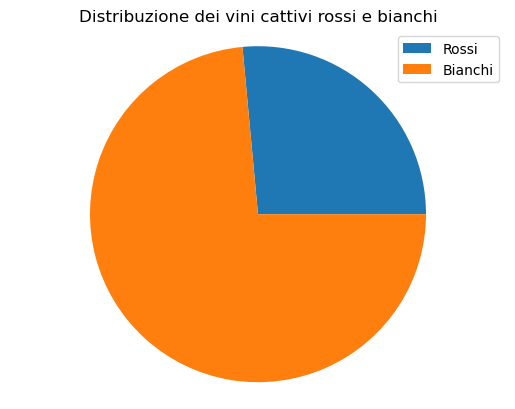

In [151]:
# ottengo tutte le righe con qualità >= 7 
nGood = WineQualities[WineQualities['quality'] >= 7].shape[0]
nBad = WineQualities[WineQualities['quality'] < 7].shape[0]

plt.figure(figsize=(10, 5))
plt.pie([nGood, nBad])
plt.title('Distribuzione della qualità del vino')
plt.legend(['Buono', 'Cattivo'], loc='upper right')
plt.axis('equal')
plt.show()

# Visualizziamo ora quanti dei vini buoni sono bianchi e quanti rossi
nRed = getGoodReds(WineQualities).shape[0]
nWhite = getGoodWhites(WineQualities).shape[0]
plt.pie([nRed, nWhite])
plt.title('Distribuzione dei vini buoni rossi e bianchi')
plt.legend(['Rossi', 'Bianchi'], loc='upper right')
plt.axis('equal')
plt.show()
# Visualizziamo ora quanti dei vini cattivi sono bianchi e quanti rossi
nRed = getBadReds(WineQualities).shape[0]
nWhite = getBadWhites(WineQualities).shape[0]
plt.pie([nRed, nWhite])
plt.title('Distribuzione dei vini cattivi rossi e bianchi')
plt.legend(['Rossi', 'Bianchi'], loc='upper right')
plt.axis('equal')
plt.show()

In [152]:
print(f"n Vini Rossi => {getReds(WineQualities).shape[0]}\nn Vini Bianchi => {getWhites(WineQualities).shape[0]}")
getGoodReds(WineQualities).describe()

n Vini Rossi => 1599
n Vini Bianchi => 4898


,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,217.0,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,1.0,8.847005,0.405530,0.376498,2.708756,0.075912,13.981567,34.889401,0.996030,3.288802,0.743456,11.518049,7.082949
std,0.0,1.999977,0.144963,0.194438,1.363026,0.028480,10.234615,32.572238,0.002201,0.154478,0.134038,0.998153,0.276443
min,1.0,4.900000,0.120000,0.000000,1.200000,0.012000,3.000000,7.000000,0.990640,2.880000,0.390000,9.200000,7.000000
25%,1.0,7.400000,0.300000,0.300000,2.000000,0.062000,6.000000,17.000000,0.994700,3.200000,0.650000,10.800000,7.000000
50%,1.0,8.700000,0.370000,0.400000,2.300000,0.073000,11.000000,27.000000,0.995720,3.270000,0.740000,11.600000,7.000000
75%,1.0,10.100000,0.490000,0.490000,2.700000,0.085000,18.000000,43.000000,0.997350,3.380000,0.820000,12.200000,7.000000
max,1.0,15.600000,0.915000,0.760000,8.900000,0.358000,54.000000,289.000000,1.003200,3.780000,1.360000,14.000000,8.000000


In [153]:
getGoodWhites(WineQualities).describe()

,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1060.0,1059.000000,1058.000000,1060.000000,1059.000000,1060.000000,1060.000000,1060.000000,1060.000000,1058.000000,1060.000000,1060.000000,1060.000000
mean,0.0,6.725637,0.265402,0.326057,5.264306,0.038160,34.550472,125.245283,0.992412,3.214820,0.500142,11.416022,7.174528
std,0.0,0.768992,0.094051,0.080288,4.291906,0.011145,13.797146,32.724848,0.002772,0.157121,0.133044,1.255209,0.391978
min,0.0,3.900000,0.080000,0.010000,0.800000,0.012000,5.000000,34.000000,0.987110,2.840000,0.220000,8.500000,7.000000
25%,0.0,6.200000,0.190000,0.280000,1.800000,0.031000,25.000000,101.000000,0.990500,3.100000,0.400000,10.700000,7.000000
50%,0.0,6.700000,0.250000,0.310000,3.900000,0.037000,33.000000,122.000000,0.991730,3.200000,0.480000,11.500000,7.000000
75%,0.0,7.200000,0.320000,0.360000,7.400000,0.044000,42.000000,146.000000,0.993605,3.320000,0.580000,12.400000,7.000000
max,0.0,9.200000,0.760000,0.740000,19.250000,0.135000,108.000000,229.000000,1.000600,3.820000,1.080000,14.200000,9.000000


Per prima cosa possiamo notare come circa il 75% del dataset è composto da vini bianchi, e poi possiamo notare come le sostanze chimiche varino di molto in base al tipo del vino.  
Come possiamo infatti notare sotto abbiamo che:
| Tipo vino | Fixed Acidity (mean) | Volatile Acidity (mean) | Citric Acid (mean) | Residual Sugar (mean) | Chlorides (mean) | Free Sulfur Dioxide (mean) | Total Sulfur Dioxide (mean) | Density (mean) | pH (mean)   | Sulphates (mean) | Alcohol (mean) |
|-----------|----------------|------------------|-------------|----------------|-----------|----------|------------|---------|------|------------|---------|
| White     | 6.86 (- ~18%)  | 0.28 (- ~47%)     | 0.33 (+ ~23%) | 6.39 (+ ~150%) | 0.046 (- ~47%) | 35.3 (+ ~122%) | 138.4 (+ ~198%) | 0.9940 (-) | 3.19 (-) | 0.49 (- ~26%) | 10.51 (+) |
| Red       | 8.32           | 0.53              | 0.27         | 2.54           | 0.087           | 15.9           | 46.5            | 0.9967     | 3.31     | 0.66          | 10.42    |

Osservando la comparazione tra i due tipi posso dire che un vino bianco ha generalmente:
- meno acidità fissa => i vini bianchi hanno un sapore meno strutturato
- la metà degli acidi volatili => i rossi hanno un aroma molto più pungente di un bianco
- 1/4 in più di acido citrico => i bianchi danno al palato una sensazione maggiore di freschezza
- 3 volte gli zuccheri residui di un rosso => il sapore rimane molto più dolce
- la metà dei cloruri il che lo rende meno sapido
- molti più sulfuri totali e libero, i quali lo proteggono dall'ossidazione
- 1/4 in meno di solfati, quindi una minore stabilità microbiologica 


In [154]:
white_wine = getWhites(WineQualities)
red_wine = getReds(WineQualities)

white_desc = white_wine[chemical_features[0:len(chemical_features)//2]].describe()
red_desc = red_wine[chemical_features[0:len(chemical_features)//2]].describe()

white_desc.columns = [col + '_white' for col in white_desc.columns]
red_desc.columns = [col + '_red' for col in red_desc.columns]

comparison = pd.concat([white_desc, red_desc], axis=1)
comparison = comparison[comparison.columns.sort_values()]
comparison


,chlorides_red,chlorides_white,citric acid_red,citric acid_white,fixed acidity_red,fixed acidity_white,residual sugar_red,residual sugar_white,volatile acidity_red,volatile acidity_white
count,1599.000000,4896.000000,1598.000000,4896.000000,1597.000000,4890.000000,1599.000000,4896.000000,1598.000000,4891.000000
mean,0.087467,0.045778,0.271145,0.334250,8.322104,6.855532,2.538806,6.393250,0.527738,0.278252
std,0.047065,0.021850,0.194744,0.120985,1.740767,0.843808,1.409928,5.072275,0.179085,0.100811
min,0.012000,0.009000,0.000000,0.000000,4.600000,3.800000,0.900000,0.600000,0.120000,0.080000
25%,0.070000,0.036000,0.090000,0.270000,7.100000,6.300000,1.900000,1.700000,0.390000,0.210000
50%,0.079000,0.043000,0.260000,0.320000,7.900000,6.800000,2.200000,5.200000,0.520000,0.260000
75%,0.090000,0.050000,0.420000,0.390000,9.200000,7.300000,2.600000,9.900000,0.640000,0.320000
max,0.611000,0.346000,1.000000,1.660000,15.900000,14.200000,15.500000,65.800000,1.580000,1.100000


In [155]:
white_desc = white_wine[chemical_features[len(chemical_features)//2:]].describe()
red_desc = red_wine[chemical_features[len(chemical_features)//2:]].describe()

white_desc.columns = [col + '_white' for col in white_desc.columns]
red_desc.columns = [col + '_red' for col in red_desc.columns]

comparison = pd.concat([white_desc, red_desc], axis=1)
comparison = comparison[comparison.columns.sort_values()]
comparison

,alcohol_red,alcohol_white,density_red,density_white,free sulfur dioxide_red,free sulfur dioxide_white,pH_red,pH_white,sulphates_red,sulphates_white,total sulfur dioxide_red,total sulfur dioxide_white
count,1599.000000,4898.000000,1599.000000,4898.000000,1599.000000,4898.000000,1597.000000,4891.000000,1597.000000,4896.000000,1599.000000,4898.000000
mean,10.422983,10.514267,0.996747,0.994027,15.874922,35.308085,3.310864,3.188203,0.658078,0.489835,46.467792,138.360657
std,1.065668,1.230621,0.001887,0.002991,10.460157,17.007137,0.154290,0.151014,0.169594,0.114147,32.895324,42.498065
min,8.400000,8.000000,0.990070,0.987110,1.000000,2.000000,2.740000,2.720000,0.330000,0.220000,6.000000,9.000000
25%,9.500000,9.500000,0.995600,0.991723,7.000000,23.000000,3.210000,3.090000,0.550000,0.410000,22.000000,108.000000
50%,10.200000,10.400000,0.996750,0.993740,14.000000,34.000000,3.310000,3.180000,0.620000,0.470000,38.000000,134.000000
75%,11.100000,11.400000,0.997835,0.996100,21.000000,46.000000,3.400000,3.280000,0.730000,0.550000,62.000000,167.000000
max,14.900000,14.200000,1.003690,1.038980,72.000000,289.000000,4.010000,3.820000,2.000000,1.080000,289.000000,440.000000


Ora posso passare ad analizzare e a confrontare le caratteristiche chimiche tra i vini bianchi buoni e non buoni, per poi farlo anche con i rossi:

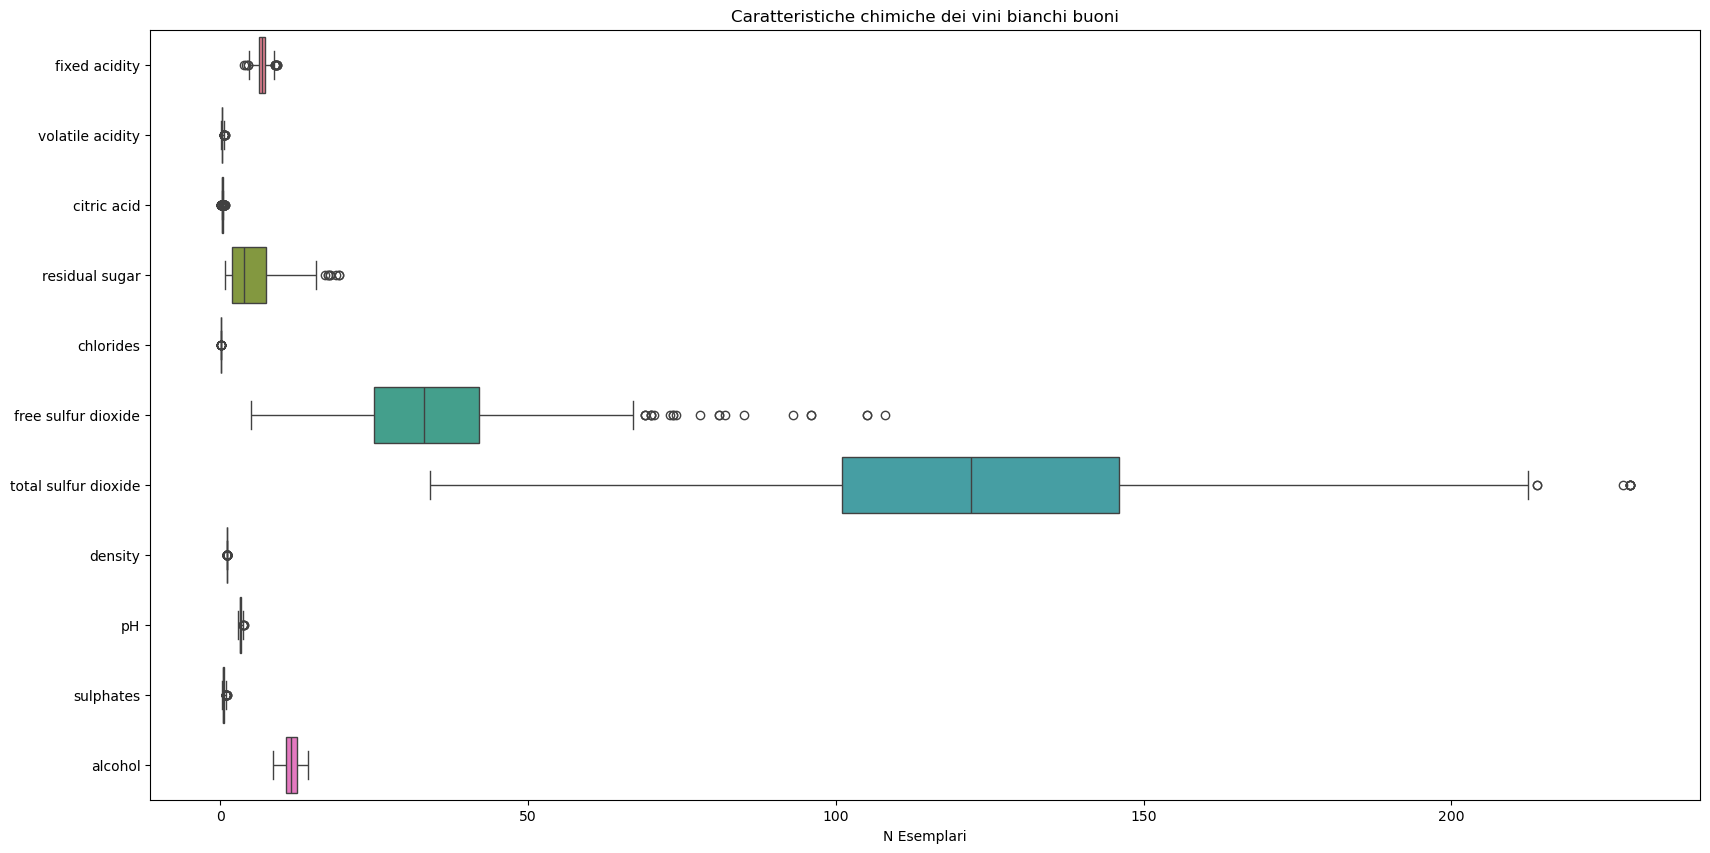

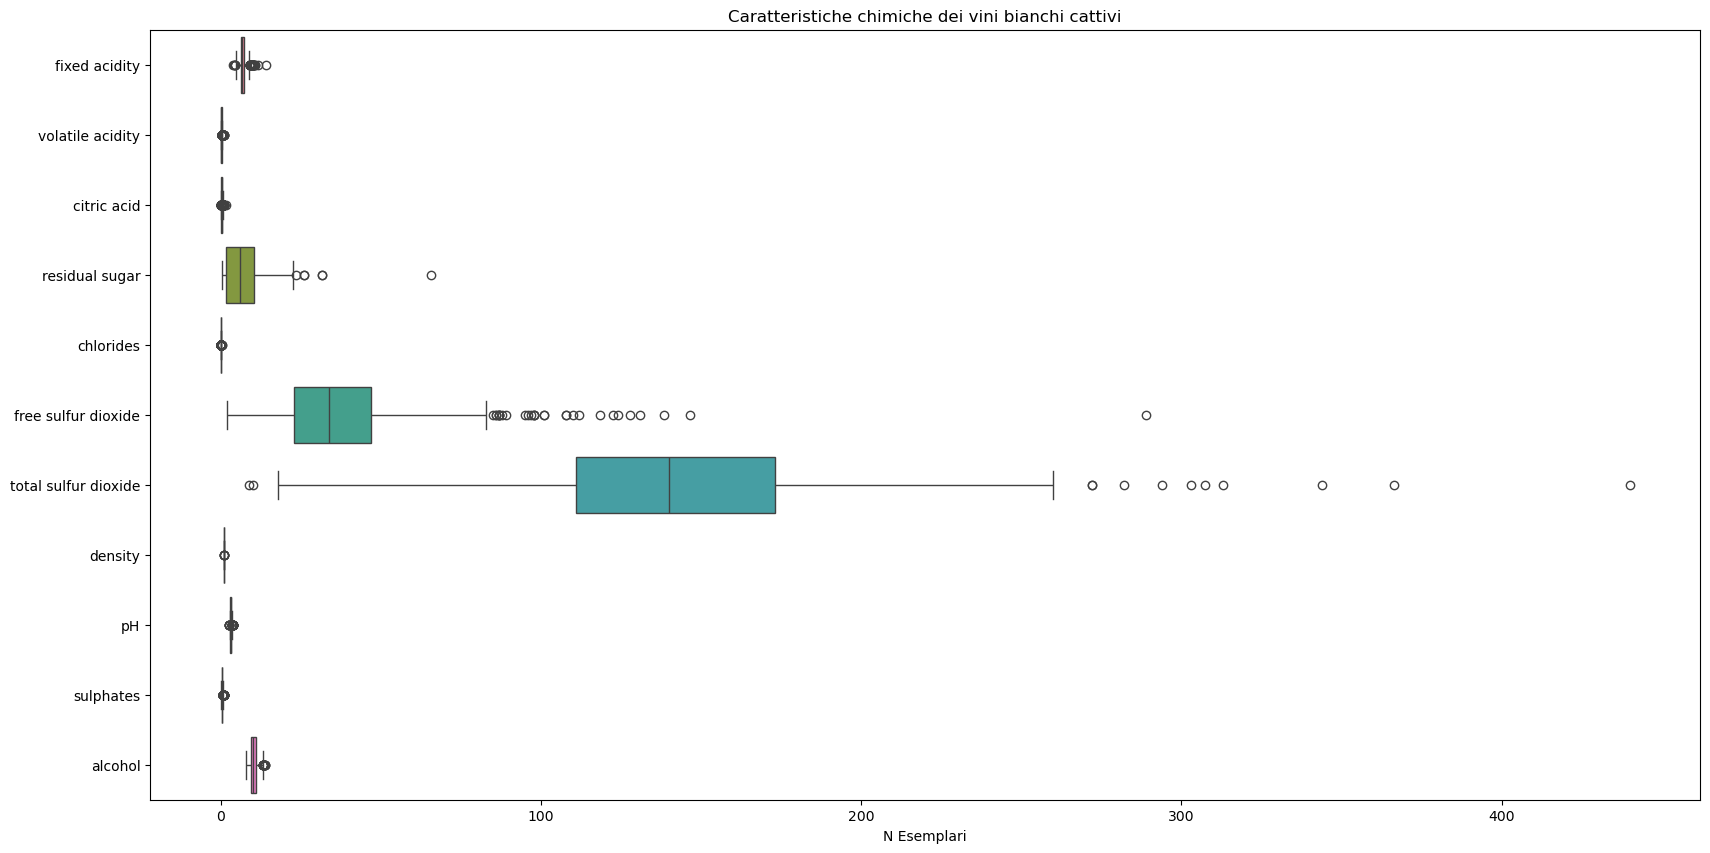

In [156]:
def showBoxes(values,title):
    plt.figure(figsize=(20, 10))
    sb.boxplot(data=values[chemical_features], orient='h')
    plt.title(title)
    plt.xlabel('N Esemplari')
    plt.show()    

goodWhites = getGoodWhites(WineQualities)
badWhites = getBadWhites(WineQualities)

# Visualizziamo le caratteristiche chimiche dei vini bianchi buoni e cattivi
showBoxes(goodWhites, 'Caratteristiche chimiche dei vini bianchi buoni')
showBoxes(badWhites, 'Caratteristiche chimiche dei vini bianchi cattivi')


In linea generale posso notare che i vini <strong>bianchi</strong> "buoni" hanno una distribuzione dei valori chimici più compatte suggerendo la presenza di valori standard per ottenere un vino buono, inoltre:
- Un vino cattivo ha i valori volatile acidity più alti
- Alcohol, Free sulfur dioxide e total sulfur dioxide più alti nei vini buoni

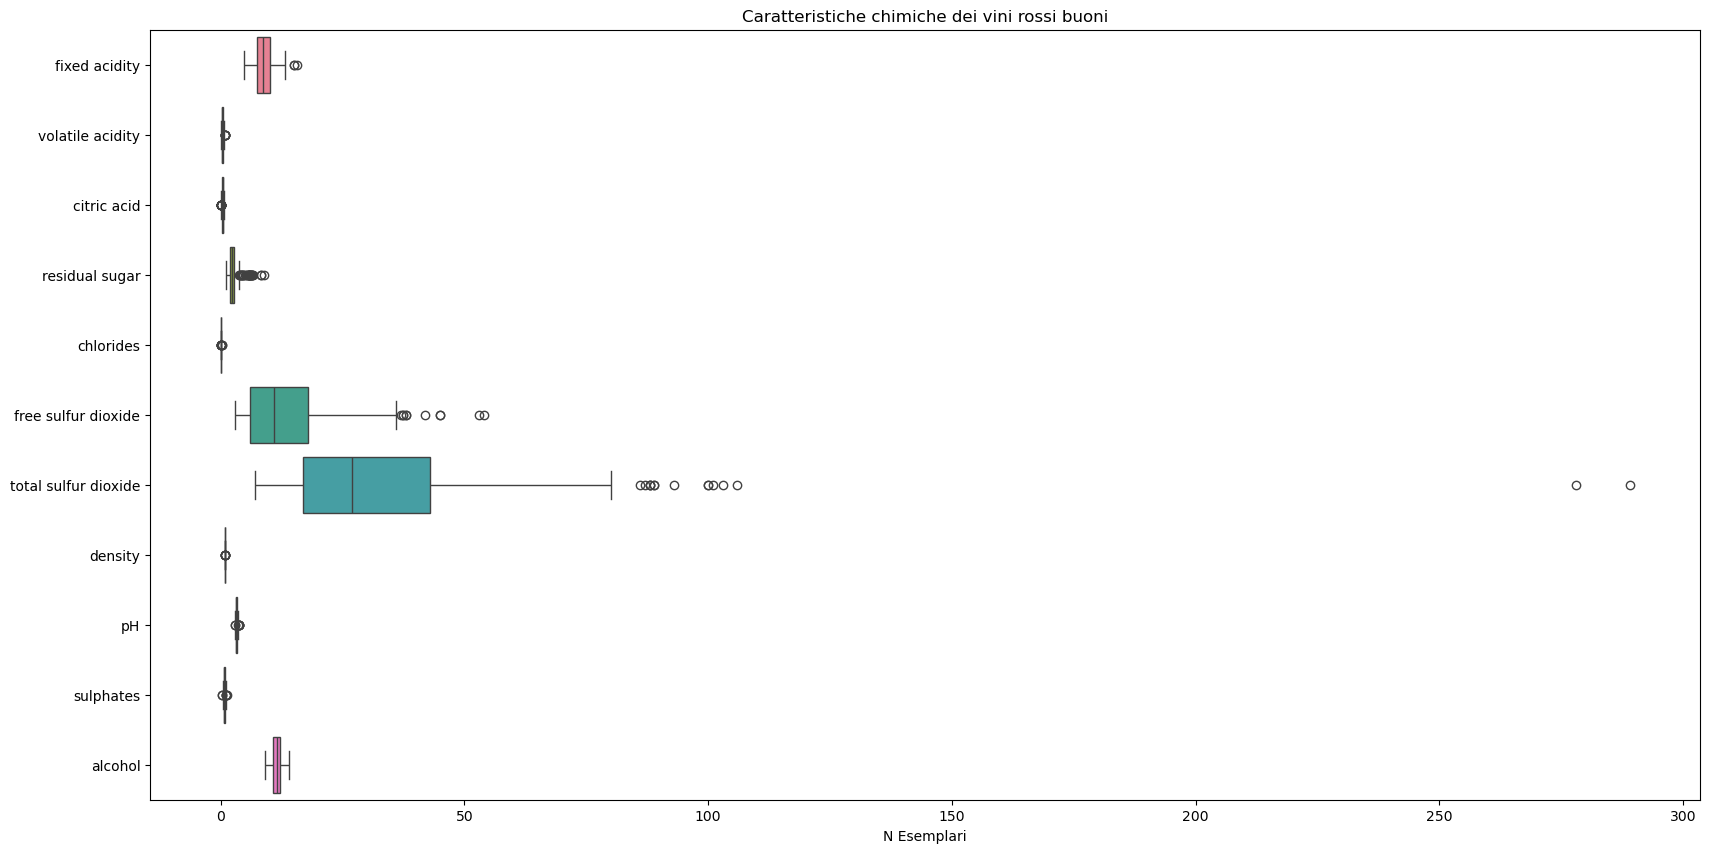

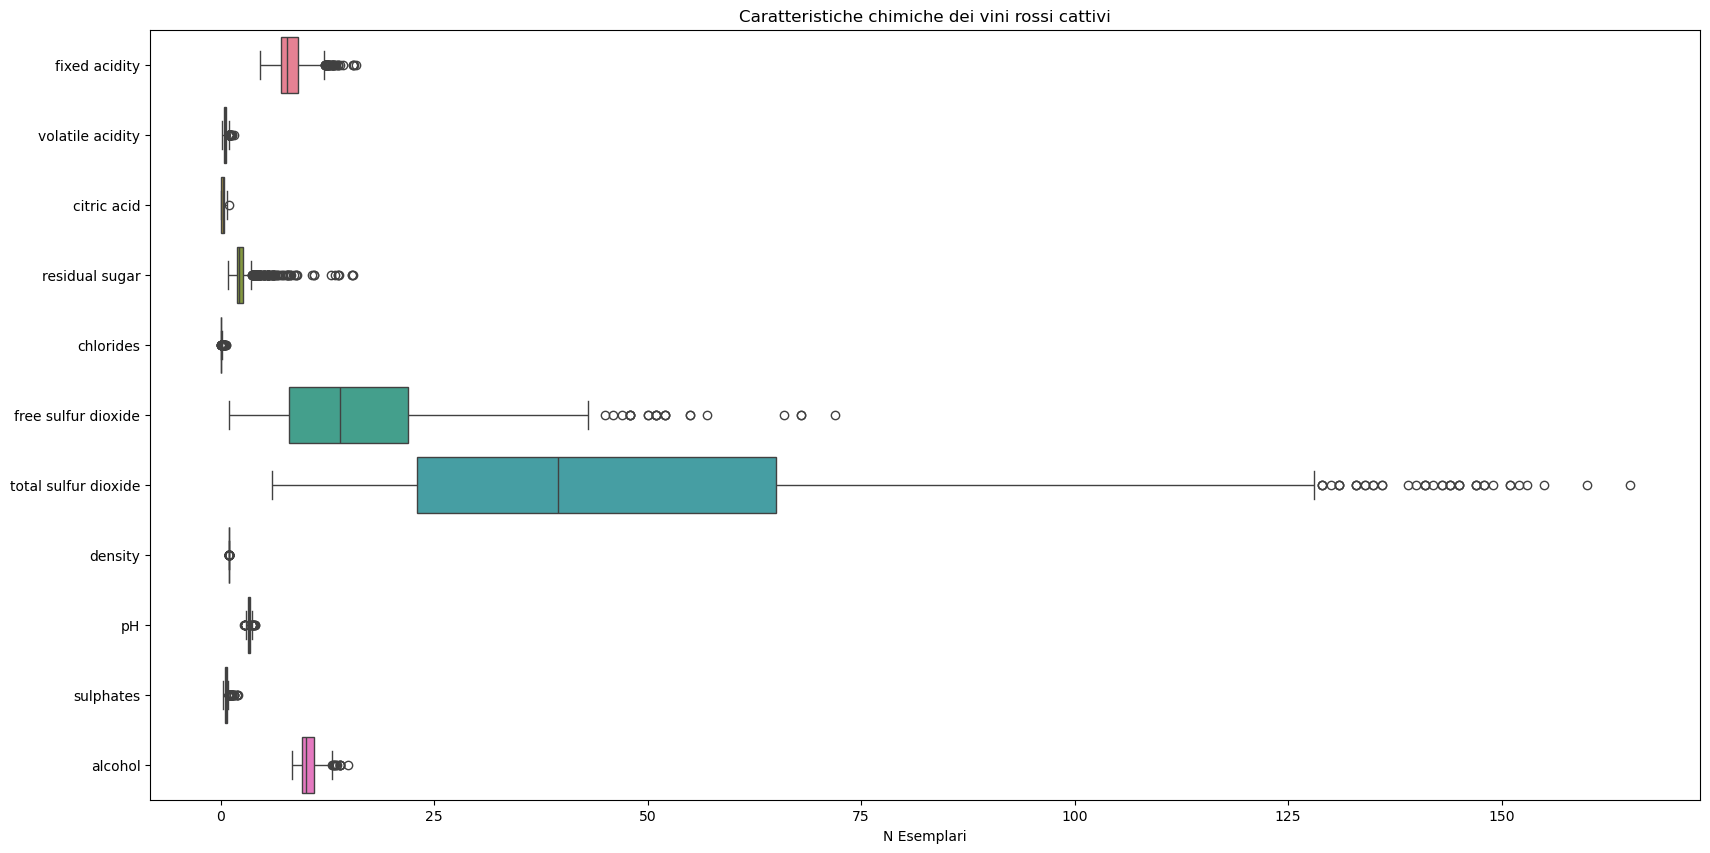

In [157]:
goodReds = getGoodReds(WineQualities)
badReds = getBadReds(WineQualities)

# Visualizziamo le caratteristiche chimiche dei vini rossi buoni e cattivi
showBoxes(goodReds, 'Caratteristiche chimiche dei vini rossi buoni')
showBoxes(badReds, 'Caratteristiche chimiche dei vini rossi cattivi')

Anche per i rossi possiamo notare la presenza delle "linee guida" per i valori chimici ed in più:
- Alcohol anche qui più elevato per i vini di qualità
- I solfati liberi e totali sono molto maggiori nei vini cattivi, così come anche la fixed acidity e gli zuccheri residui

### Preparazione dei dati

Per prima cosa non posso passare ai modelli dei campi NaN quindi ho diverse possibilità per assegnarle:
1. Assegnare tutti i valori NaN a 0
2. Assegnare ai valori NaN di una determinata colonna la sua media rispetto a tutto il dataframe
3. Assegnare ai valori NaN di una determinata colonna il suo minimo rispetto a tutto il dataframe
4. Assegnare ai valori NaN di una determinata colonna la media di quella colonna rispetto a tutti i vini con lo stesso color e la stessa qualità <---  

La strada più sensata ritengo sia la 4. poichè permette al valore di avere più significato rispetto alle altre soluzioni.  

In [158]:
# cicla su tutti i valori NaN
for col in WineQualities.columns:
    if WineQualities[col].isnull().any():
        # Ottiengo le righe con valori NaN per il colonna corrente
        nan_row = WineQualities[WineQualities[col].isnull()]
        for index, row in nan_row.iterrows():
            rowToMean = WineQualities[WineQualities['color'] == row['color']]
            rowToMean = rowToMean[rowToMean['quality'] == row['quality']]
            if not rowToMean.empty:
                mean_value = rowToMean[col].mean()
                WineQualities.at[index, col] = mean_value
            else:
                exit(f"Nessun valore trovato per la colonna {col} con qualità {row['quality']} e colore {row['color']}")
# Verifica che non ci siano più valori NaN
print(WineQualities.isnull().sum())

color                   0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Per quanto riguarda i modelli da implementare ritengo opportuno testare i risultati utilizzando i seguenti modelli:
- Logisti Regression
- Random Forest 
- SVM 
- NN (Classifier)

Per i primi tre modelli le classi da prevedere sono le seguenti:
- Buono
- Cattivo

Mentre per il classificatore le classi sono le seguenti:
- Bianco Buono
- Bianco Cattivo
- Rosso Buono
- Rosso Cattivo

I dati che passerò ai modelli saranno composti nel seguente modo:
- training set (set di X e set di Y)  85% del dataset
- test set (set di X e set di Y) 15% del dataset

In [159]:
# Funzione per creare le etichette multiclasse
def create_multiclass_class_names(data):
    """
    Crea le etichette per classificazione a 4 classi:
    0: Bianco Cattivo (quality < 7, color = 0)
    1: Bianco Buono (quality >= 7, color = 0) 
    2: Rosso Cattivo (quality < 7, color = 1)
    3: Rosso Buono (quality >= 7, color = 1)
    """
    class_names = []
    for _, row in data.iterrows():
        if row['color'] == 0 and row['quality'] < 7:
            class_names.append(0)
        elif row['color'] == 0 and row['quality'] >= 7:
            class_names.append(1)
        elif row['color'] == 1 and row['quality'] < 7:
            class_names.append(2)
        else:
            class_names.append(3)
    return np.array(class_names)

# 1. Features e variabili target
X = WineQualities.drop(columns=['quality'])
y_continuous = WineQualities['quality']
y_binary = (y_continuous >= 7).astype(int)
y_multi = create_multiclass_class_names(WineQualities)

# 2. Divisione stratificata (usiamo y_binary per garantire bilanciamento)
train_X, test_X, train_y_binary, test_y_binary = train_test_split(
    X, y_binary, test_size=0.15, random_state=42, stratify=y_binary
)

# 3. Indici per assegnare gli altri target
train_indices = train_X.index
test_indices = test_X.index

train_y_multi = y_multi[train_indices]
test_y_multi = y_multi[test_indices]

train_y_continuous = y_continuous.iloc[train_indices]
test_y_continuous = y_continuous.iloc[test_indices]

# 5. Standardizzazione (necessaria per modelli sensibili alla scala)
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# 6. Info utili
print("Distribuzione classi nel training set:")
class_names = ['Bianco Cattivo', 'Bianco Buono', 'Rosso Cattivo', 'Rosso Buono']
unique_train, counts_train = np.unique(train_y_multi, return_counts=True)
for i, count in zip(unique_train, counts_train):
    print(f"  {class_names[i]}: {count} ({count/len(train_y_multi)*100:.1f}%)")

print("\nDistribuzione classi nel test set:")
unique_test, counts_test = np.unique(test_y_multi, return_counts=True)
for i, count in zip(unique_test, counts_test):
    print(f"  {class_names[i]}: {count} ({count/len(test_y_multi)*100:.1f}%)")

print(f"\nDimensioni training set: {train_X.shape}")
print(f"Dimensioni test set: {test_X.shape}")


Distribuzione classi nel training set:
  Bianco Cattivo: 3261 (59.1%)
  Bianco Buono: 894 (16.2%)
  Rosso Cattivo: 1176 (21.3%)
  Rosso Buono: 191 (3.5%)

Distribuzione classi nel test set:
  Bianco Cattivo: 577 (59.2%)
  Bianco Buono: 166 (17.0%)
  Rosso Cattivo: 206 (21.1%)
  Rosso Buono: 26 (2.7%)

Dimensioni training set: (5522, 12)
Dimensioni test set: (975, 12)


Analizzando le classi si nota come le classi siano molto squilibrate, ci sono troppi bianchi cattivi rispetto al resto delle classi.  
Si potrebbe provare ad usare dei dati sintetici per bilanciarle, oppure provare ad usare class_weight="balanced", di seguito provo ad usare il secondo approccio, cercando di ottimizzare per il parametro "f1_macro", dato che cercare la maggiore accuracy in questo contesto non ha molto senso, perchè il modello sarebbe poi molto accurato nel predirre la classe Bianco Cattivo ma non saprebbe riconoscere le restanti classi più deboli.

### Modelli

##### Linear Regression

In [160]:
lr_reg = LinearRegression()
lr_reg.fit(train_X_scaled, train_y_continuous)

lr_pred = lr_reg.predict(test_X_scaled)
mse_lr = mean_squared_error(test_y_continuous, lr_pred)
r2_lr = r2_score(test_y_continuous, lr_pred)

print(f"MSE Linear Regression: {mse_lr:.4f}")
print(f"MAE Linear Regression: {mean_absolute_error(test_y_continuous, lr_pred):.4f}")
print(f"R² Linear Regression: {r2_lr:.4f}")


MSE Linear Regression: 0.5462
MAE Linear Regression: 0.5754
R² Linear Regression: 0.3032


##### Random Forest Regression

MSE Random Forest Regressor: 0.3674
MAE Random Forest Regressor: 0.4266
R² Random Forest Regressor: 0.5312


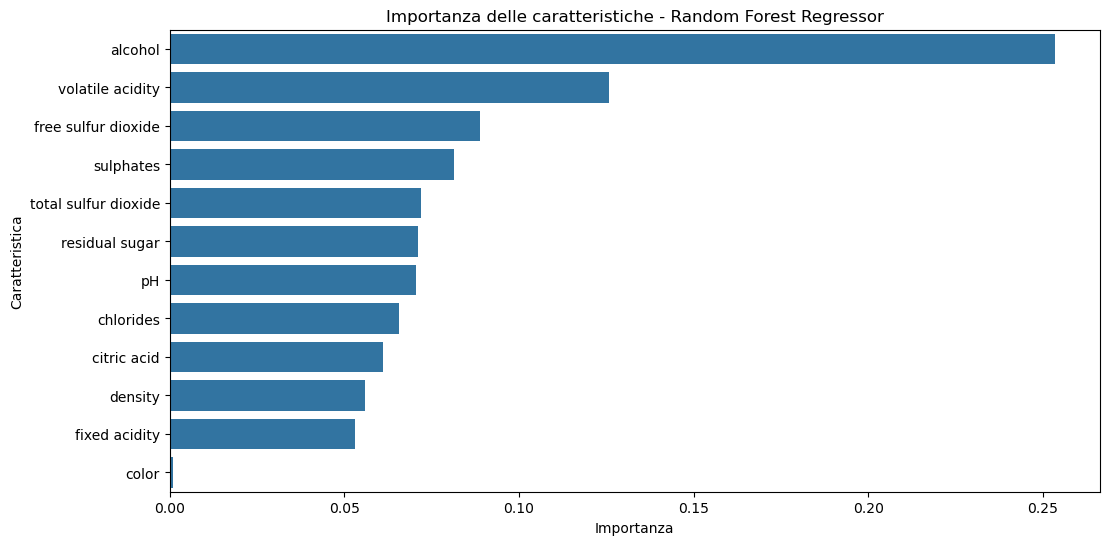

In [161]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_reg.fit(train_X, train_y_continuous)

rf_pred = rf_reg.predict(test_X)
mse_rf = mean_squared_error(test_y_continuous, rf_pred)
r2_rf = r2_score(test_y_continuous, rf_pred)

print(f"MSE Random Forest Regressor: {mse_rf:.4f}")
print(f"MAE Random Forest Regressor: {mean_absolute_error(test_y_continuous, rf_pred):.4f}")
print(f"R² Random Forest Regressor: {r2_rf:.4f}")

# Feature importance
importance_df = pd.DataFrame({
    'feature': train_X.columns,
    'importance': rf_reg.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sb.barplot(x='importance', y='feature', data=importance_df)
plt.title('Importanza delle caratteristiche - Random Forest Regressor')
plt.xlabel('Importanza')
plt.ylabel('Caratteristica')
plt.show()


Random forest conferma che le feature alcohol, volatile acidity, il solfuro di zolfo libero e totale ed i solfati sono i principali parametri che permettono la previsione della qualità del vino.

##### SVM Classifier

In [162]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', classes=class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Accuratezza SVM Classificatore: 0.7528
Classification Report:
              precision    recall  f1-score   support

     Cattivo       0.95      0.73      0.83       783
       Buono       0.43      0.84      0.57       192

    accuracy                           0.75       975
   macro avg       0.69      0.79      0.70       975
weighted avg       0.85      0.75      0.78       975



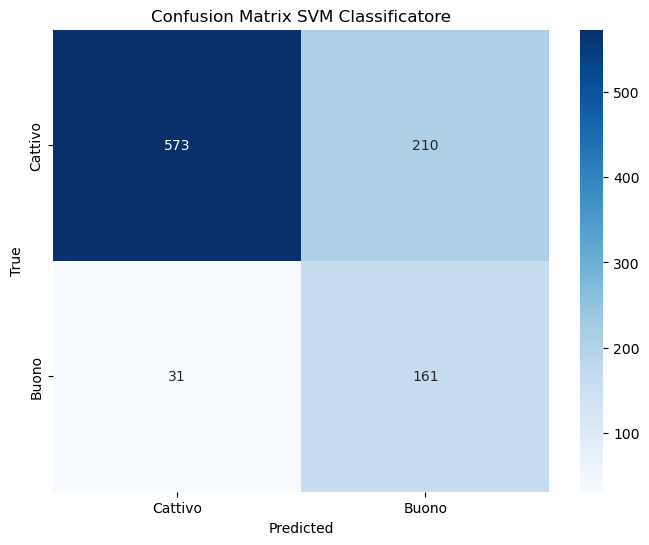

In [163]:
## Classificazione binaria con SVM
train_y_class = train_y_binary 
test_y_class = test_y_binary  

svm_cls = SVC(kernel='rbf', random_state=42, probability=True,class_weight='balanced')
svm_cls.fit(train_X_scaled, train_y_class)

svm_pred = svm_cls.predict(test_X_scaled)
acc_svm = accuracy_score(test_y_class, svm_pred)

print(f"Accuratezza SVM Classificatore: {acc_svm:.4f}")
print("Classification Report:")
print(classification_report(test_y_class, svm_pred, target_names=['Cattivo', 'Buono']))
plot_confusion_matrix(test_y_class, svm_pred, title='Confusion Matrix SVM Classificatore',classes=['Cattivo', 'Buono'])

Accuratezza SVM Classificatore: 0.7631
Classification Report:
                precision    recall  f1-score   support

Bianco Cattivo       0.93      0.73      0.82       577
  Bianco Buono       0.47      0.82      0.60       166
 Rosso Cattivo       0.97      0.79      0.87       206
   Rosso Buono       0.33      0.81      0.47        26

      accuracy                           0.76       975
     macro avg       0.68      0.79      0.69       975
  weighted avg       0.85      0.76      0.79       975



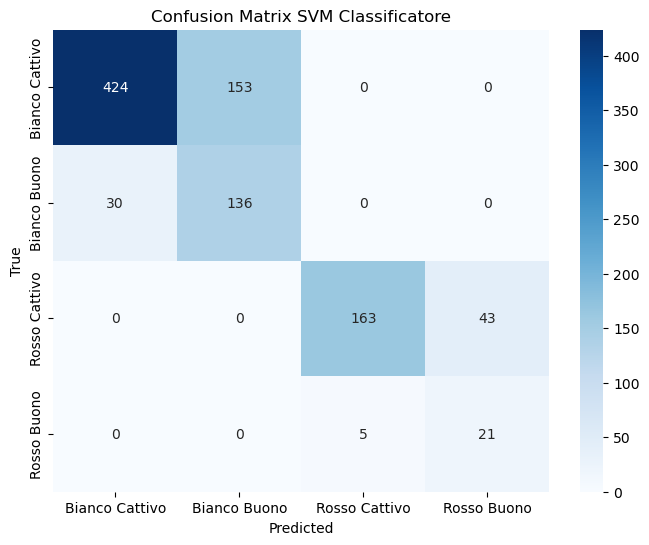

In [164]:
# Classificazione multiclasse con SVM
train_y_class = train_y_multi
test_y_class = test_y_multi     

svm_cls = SVC(kernel='rbf', random_state=42, probability=True,class_weight='balanced')
svm_cls.fit(train_X_scaled, train_y_class)

svm_pred = svm_cls.predict(test_X_scaled)
acc_svm = accuracy_score(test_y_class, svm_pred)

print(f"Accuratezza SVM Classificatore: {acc_svm:.4f}")
print("Classification Report:")
print(classification_report(test_y_class, svm_pred, target_names=class_names))
plot_confusion_matrix(test_y_class, svm_pred, title='Confusion Matrix SVM Classificatore')

## K-Fold Cross Validation 

Validato tutti i modelli facendo la cross validation per confrontarli fra loro ed arrivare a poter scegliere il migliore fra loro:  


--- KFold Cross-Validation Results ---
Regressione Lineare (R²):     0.2935 ± 0.0282
Random Forest Regressor (R²): 0.5218 ± 0.0356
SVM Binaria (Accuracy):     0.7533 ± 0.0150
SVM Multiclasse (Accuracy): 0.7568 ± 0.0101


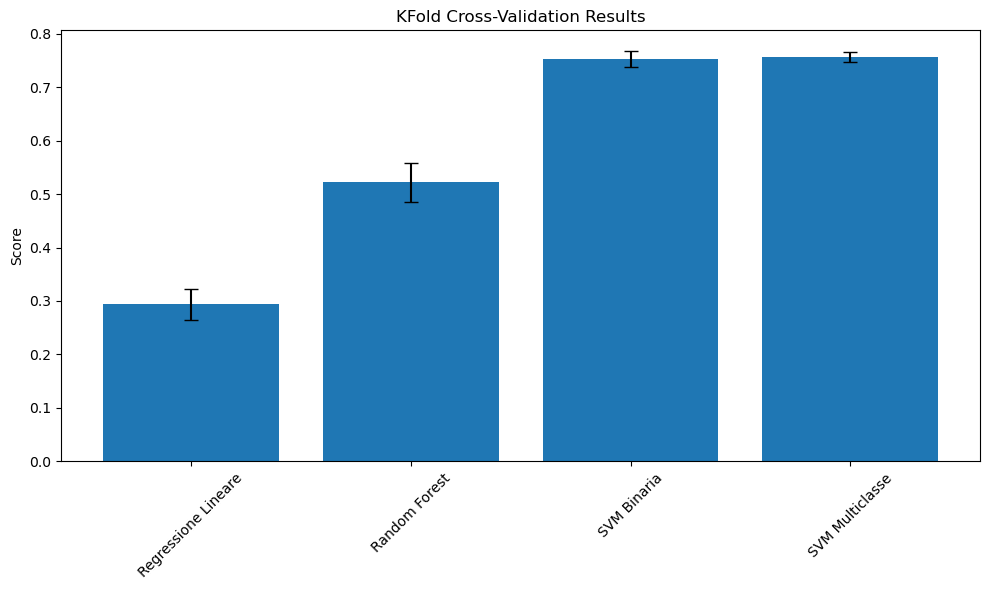

In [165]:
X_scaled = StandardScaler().fit_transform(X)

# Regressione Lineare su qualità continua
lr_model = LinearRegression()
kf_reg = KFold(n_splits=5, shuffle=True, random_state=42)
lr_scores = cross_val_score(lr_model, X_scaled, y_continuous, cv=kf_reg, scoring='r2')

# Random Forest Regressor su qualità continua
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_scores = cross_val_score(rf_model, X, y_continuous, cv=kf_reg, scoring='r2')

# SVM per classificazione binaria
svm_binary = SVC(kernel='rbf', random_state=42,class_weight='balanced')
kf_bin = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_binary_scores = cross_val_score(svm_binary, X_scaled, y_binary, cv=kf_bin, scoring='accuracy')

# SVM per classificazione multiclasse
svm_multi = SVC(kernel='rbf', random_state=42,class_weight='balanced')
kf_multi = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_multi_scores = cross_val_score(svm_multi, X_scaled, y_multi, cv=kf_multi, scoring='accuracy')

# Risultati
print("\n--- KFold Cross-Validation Results ---")
print(f"Regressione Lineare (R²):     {np.mean(lr_scores):.4f} ± {np.std(lr_scores):.4f}")
print(f"Random Forest Regressor (R²): {np.mean(rf_scores):.4f} ± {np.std(rf_scores):.4f}")
print(f"SVM Binaria (Accuracy):     {np.mean(svm_binary_scores):.4f} ± {np.std(svm_binary_scores):.4f}")
print(f"SVM Multiclasse (Accuracy): {np.mean(svm_multi_scores):.4f} ± {np.std(svm_multi_scores):.4f}")

plt.figure(figsize=(10, 6))
plt.bar(['Regressione Lineare', 'Random Forest', 'SVM Binaria', 'SVM Multiclasse'],
        [np.mean(lr_scores), np.mean(rf_scores), np.mean(svm_binary_scores), np.mean(svm_multi_scores)],
        yerr=[np.std(lr_scores), np.std(rf_scores), np.std(svm_binary_scores), np.std(svm_multi_scores)],
        capsize=5)
plt.title('KFold Cross-Validation Results')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Ottimizzazione del modello SVM

Analizzando il grafico prodotto dalla K-fold cross validation si può notare come il modello migliore sia l'SVM a classificazione binaria e multiclasse, quindi proviamo ad ottimizare i suoi iperparametri utilizzando la Grid Search:

In [166]:
svc = SVC()
params_svm = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear'],
    'class_weight': ['balanced', None]
}

grid_svm = GridSearchCV(svc, param_grid=params_svm, scoring='accuracy', cv=5,n_jobs=-1, verbose=1)
grid_svm.fit(X_scaled, y_multi)  # y_multi: etichette 0-3

print("Miglior score accuracy:", grid_svm.best_score_)
print("Migliori parametri targettando l'accuracy:", grid_svm.best_params_)

grid_svm = GridSearchCV(svc, param_grid=params_svm, scoring='f1_macro', cv=5,n_jobs=-1, verbose=1)
grid_svm.fit(X_scaled, y_multi)  # y_multi: etichette 0-3

print("Miglior score accuracy:", grid_svm.best_score_)
print("Migliori parametri targettando f1 macro per provare ad eliminare lo sbilanciamento:", grid_svm.best_params_)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Miglior score accuracy: 0.8217653816545271
Migliori parametri targettando l'accuracy: {'C': 1, 'class_weight': None, 'gamma': 0.1, 'kernel': 'rbf'}
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Miglior score accuracy: 0.674547992188667
Migliori parametri targettando f1 macro per provare ad eliminare lo sbilanciamento: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


Quindi ora rifacciamo la cross validation con gli iperparametri forniti:

Classification Report SVM con Parametri Ottimizzati:
                precision    recall  f1-score   support

Bianco Cattivo       0.94      0.73      0.82       577
  Bianco Buono       0.47      0.83      0.60       166
 Rosso Cattivo       0.97      0.80      0.88       206
   Rosso Buono       0.34      0.81      0.48        26

      accuracy                           0.76       975
     macro avg       0.68      0.79      0.69       975
  weighted avg       0.85      0.76      0.78       975



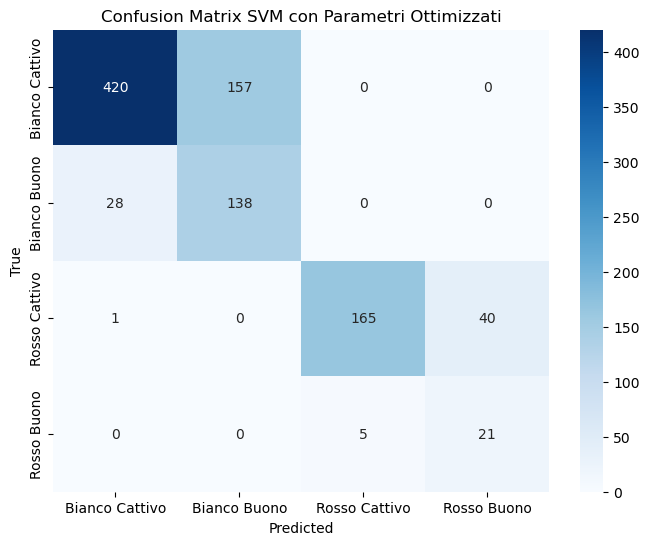

Classification Report SVM Binaria con Parametri Ottimizzati:
              precision    recall  f1-score   support

     Cattivo       0.95      0.74      0.83       783
       Buono       0.44      0.84      0.58       192

    accuracy                           0.76       975
   macro avg       0.69      0.79      0.70       975
weighted avg       0.85      0.76      0.78       975



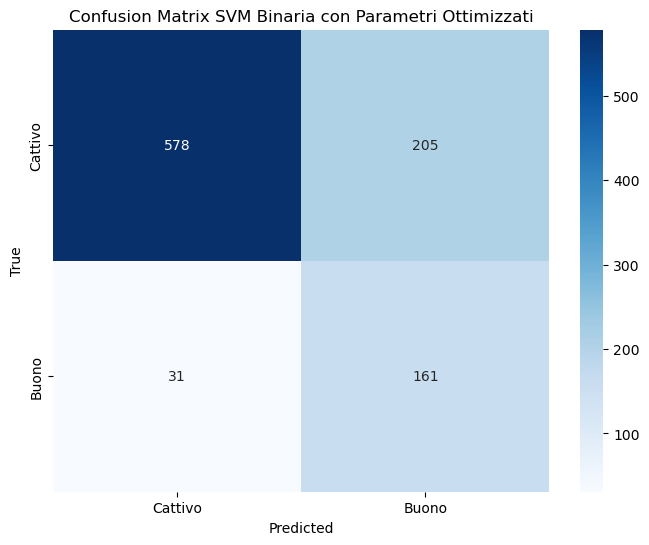

In [167]:
params = grid_svm.best_params_
svc_best = SVC(**params)
svc_best.fit(train_X_scaled, train_y_multi)
svc_pred = svc_best.predict(test_X_scaled)
print("Classification Report SVM con Parametri Ottimizzati:")
print(classification_report(test_y_multi, svc_pred, target_names=class_names))
plot_confusion_matrix(test_y_multi, svc_pred, title='Confusion Matrix SVM con Parametri Ottimizzati')
# Classificazione binaria con SVM
svc_binary = SVC(**params)
svc_binary.fit(train_X_scaled, train_y_binary)
svc_binary_pred = svc_binary.predict(test_X_scaled)
print("Classification Report SVM Binaria con Parametri Ottimizzati:")
print(classification_report(test_y_binary, svc_binary_pred, target_names=['Cattivo', 'Buono']))
plot_confusion_matrix(test_y_binary, svc_binary_pred, title='Confusion Matrix SVM Binaria con Parametri Ottimizzati', classes=['Cattivo', 'Buono'])


Confronto con il precedente modello SVM: 

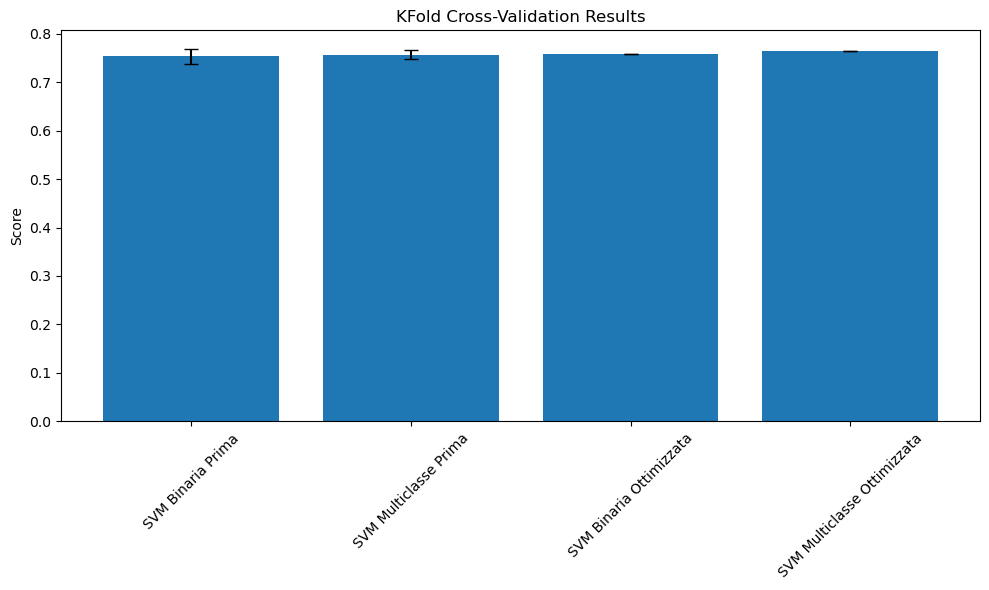

In [168]:
plt.figure(figsize=(10, 6))
plt.bar(['SVM Binaria Prima', 'SVM Multiclasse Prima', 'SVM Binaria Ottimizzata', 'SVM Multiclasse Ottimizzata'],
        [np.mean(svm_binary_scores), np.mean(svm_multi_scores), accuracy_score(test_y_binary, svc_binary_pred), accuracy_score(test_y_multi, svc_pred)],
        yerr=[np.std(svm_binary_scores), np.std(svm_multi_scores), 0, 0],
        capsize=5)
plt.title('KFold Cross-Validation Results')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ora devo decidere quale tra le due modalità sia più adeguata al mio scope, nel mio caso infatti sto cercando un modello che permetta di predirre più o meno bene tutte le classi proposte.

=== Classification Report (Accuracy-based) ===
                precision    recall  f1-score   support

Bianco Cattivo       0.84      0.97      0.90      3838
  Bianco Buono       0.74      0.34      0.46      1060
 Rosso Cattivo       0.90      0.99      0.94      1382
   Rosso Buono       0.81      0.33      0.47       217

      accuracy                           0.85      6497
     macro avg       0.82      0.65      0.69      6497
  weighted avg       0.84      0.85      0.82      6497



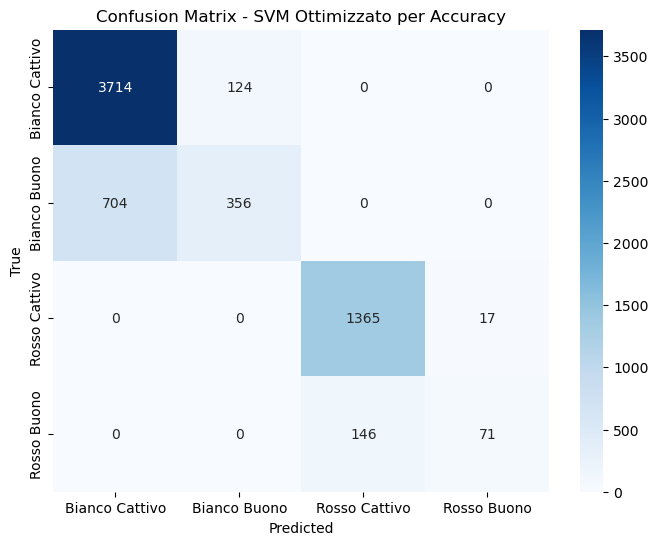


=== Classification Report (F1-macro-based) ===
                precision    recall  f1-score   support

Bianco Cattivo       0.95      0.72      0.82      3838
  Bianco Buono       0.46      0.86      0.60      1060
 Rosso Cattivo       0.98      0.84      0.91      1382
   Rosso Buono       0.48      0.90      0.62       217

      accuracy                           0.78      6497
     macro avg       0.72      0.83      0.74      6497
  weighted avg       0.86      0.78      0.80      6497



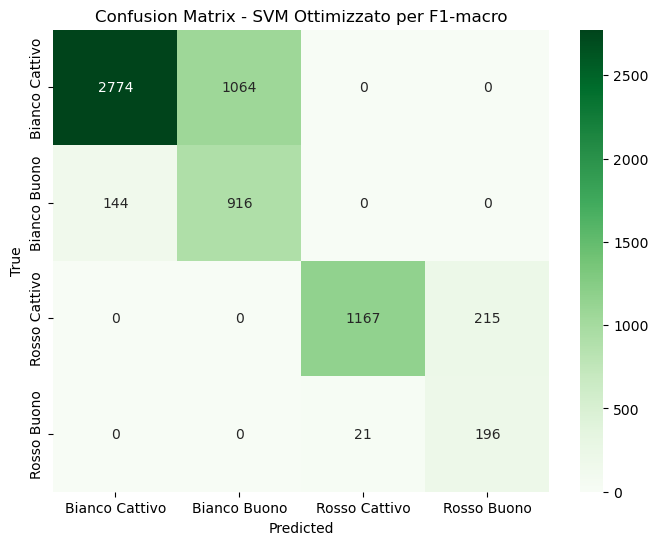

In [169]:
# Modello ottimizzato per accuracy
svm_accuracy = SVC(C=1, gamma=0.1, kernel='rbf', class_weight=None)
svm_accuracy.fit(X_scaled, y_multi)
y_pred_acc = svm_accuracy.predict(X_scaled)

# Modello ottimizzato per f1_macro
svm_f1 = SVC(C=1, gamma=0.1, kernel='rbf', class_weight='balanced')
svm_f1.fit(X_scaled, y_multi)
y_pred_f1 = svm_f1.predict(X_scaled)

labels = np.unique(y_multi)

# Confusion matrix e report - modello accuracy
print("=== Classification Report (Accuracy-based) ===")
print(classification_report(y_multi, y_pred_acc, target_names=class_names))
conf_acc = confusion_matrix(y_multi, y_pred_acc, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(conf_acc, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM Ottimizzato per Accuracy")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Confusion matrix e report - modello f1_macro
print("\n=== Classification Report (F1-macro-based) ===")
print(classification_report(y_multi, y_pred_f1, target_names=class_names))
conf_f1 = confusion_matrix(y_multi, y_pred_f1, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(conf_f1, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM Ottimizzato per F1-macro")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



Utilizzando il modello ottimizzato per f1_macro l'accuracy è minore rispetto all'ottimizzazione per accuracy ma la confusion matrix non mente, il modello in linea generale è più bilanciato e permette di predirre meglio le classi minori, quindi lo reputo adeguato per il mio scope.